In [62]:
from Bio.Seq import Seq 

In [63]:
from Bio.SeqRecord import SeqRecord

In [64]:
from Bio import SeqIO

In [65]:
input = ["../data/cvi_africa_and1001.EVA_2020-10-20.vcf.gz_dip2Norm.vcf.b.gz.vcf_atcgOnly.vcf.gz_chr1.vcf_keep-samples.vcf_biallelic.vcf_imputed.vcf.gz.est", "../data/cvi_africa_and1001.EVA_2020-10-20.vcf.gz_dip2Norm.vcf.b.gz.vcf_atcgOnly.vcf.gz_chr1.vcf_keep-samples.vcf_biallelic.vcf_imputed.vcf.gz.est_pvalues.txt"]

In [66]:
output = ["../data/test.fa"]

In [67]:
# get major and minor alleles 
majors = []
minors = []
nucs = ['A','C','G','T'] #order of nucleotides in .est files
with open(input[0], 'r') as f: #.est file
    for line in f: #go line by line
        n = [int(i) for i in line.split(' ')[0].split(',')] #count of nucleotides A,C,G,T
        majors.append(nucs[n.index(max(n))]) #major allele (i guess if they have the exact same frequency then we arbitrarily choose the first?)
        minors.append(nucs[n.index(min([i for i in n if i>0]))]) #minor allele 

In [49]:
# decide which allele is ancestral
ancestrals = majors #start by assuming the major allele is ancestral 
deriveds = minors
nflips = 0
with open(input[1], 'r') as f: #pvalues file
    for i,line in enumerate(f): #go line by line
        if float(line) < 0.5: #if the probability that the major allele is ancestral is less than 0.5 
            ancestrals[i] = minors[i] #then we make the minor allele ancestral
            deriveds[i] = majors[i]
            nflips += 1 #curious how many flips we have
print(nflips)
print(nflips/len(majors)) #fraction flipped

225959
0.052794245224232844


In [50]:
# save as fasta to polarize haps with Relate
ancestor = Seq("".join(ancestrals))
record = SeqRecord(ancestor, id="ancestral Arabidopsis thaliana sequence inferred by est-sfs;", description='outgroups: Arabidopsis lyrata, Boechera stricta, and Malcolmia maritima') #make sequence
SeqIO.write(record, output[0], "fasta") #save sequence

1

In [56]:
with open('../data/cvi_africa_and1001.EVA_2020-10-20.vcf.gz_dip2Norm.vcf.b.gz.vcf_atcgOnly.vcf.gz_chr1.vcf_keep-samples.vcf_biallelic.vcf_imputed.vcf.gz.hap') as f:
    for i,line in enumerate(f):
        if i > 10:
            break
        else:
            print(line.split(' ')[2:5])

['2', 'C', 'T']
['3', 'C', 'G']
['15', 'C', 'T']
['16', 'C', 'A']
['18', 'T', 'C']
['19', 'A', 'G']
['21', 'A', 'T']
['22', 'C', 'T']
['25', 'T', 'A']
['35', 'A', 'G']
['36', 'A', 'T']


In [79]:
    input = ["../data/cvi_africa_and1001.EVA_2020-10-20.vcf.gz_dip2Norm.vcf.b.gz.vcf_atcgOnly.vcf.gz_chr1.vcf_keep-samples.vcf_biallelic.vcf_imputed.vcf.gz.est", "../data/cvi_africa_and1001.EVA_2020-10-20.vcf.gz_dip2Norm.vcf.b.gz.vcf_atcgOnly.vcf.gz_chr1.vcf_keep-samples.vcf_biallelic.vcf_imputed.vcf.gz.est_pvalues.txt",'../data/cvi_africa_and1001.EVA_2020-10-20.vcf.gz_dip2Norm.vcf.b.gz.vcf_atcgOnly.vcf.gz_chr1.vcf_keep-samples.vcf_biallelic.vcf_imputed.vcf.gz.hap']

In [80]:
output = ["../data/test.hap"]

In [86]:
import itertools

In [152]:
nucs = ['A', 'C', 'G', 'T'] #order of nucleotides in est
nflips = 0
with open(input[0],'r') as f: #est input file with counts of alleles 
    with open(input[1],'r') as g:  #pvalues from est-sfs
        with open(input[2],'r') as h: #haps file
            with open(output[0],'w') as out: #polarized haps file
                for i, (est, p, hap) in enumerate(zip(f, g, h)): #one line at a time
                    if i < 10:
                        print(est)
                        print(hap.split(' ')[:5])
                        print(p)
                    else:
                        break
                    # get major and minor alleles
                    n = [int(i) for i in est.split(' ')[0].split(',')] #count of nucleotides
                    major = nucs[n.index(max(n))]
                    minor = nucs[n.index(min([i for i in n if i>0]))]
                    # get haps
                    haps = hap.split(' ')
                    #special cases of a fixed allele or equal frequencies will produce major==minor
                    snp = True
                    fix = False
                    if major == minor:
                        print(haps[:5])
                        print(est)
                        try:
                            [major, minor] = [nucs[i] for i,c in enumerate(n) if c == max(n)] #assign major and minor in order of nucs list
                            print('equal frequencies at snp %d, so using sister taxa'%i)
                        except:
                            print('snp %d not a snp, so not writing to outfile \n'%i)
                            snp = False
                        if snp:
                            no = [int(i) for i in est.split(' ')[1].split(',')] #nucleotide counts for closest outgroup
                            if sum(no) == 1:
                                fix = True
                            else:
                                print('no info from sister taxa, so moving to next outgroup')
                                no = [int(i) for i in est.split(' ')[2].split(',')] #next closest outgroup
                                if sum(no) == 1:
                                    fix = True
                                else:
                                    print('no info from cousin taxa, so moving to next outgroup')
                                    no = [int(i) for i in est.split(' ')[3].split(',')] #next closest outgroup
                                    if sum(no) == 1:
                                        fix = True
                                    else:
                                        print('no info from any outgroup, so choosing major as first allele in nucs list')
                                        print(major, minor)
                                        print(p)
                                        print('\n')
                    if fix:
                        if major == nucs[no.index(max(no))]: #if the major allele matches the outgroup
                                # done
                                print(major, minor)
                                print('\n')                            
                        elif minor == nucs[no.index(max(no))]: #if the minor matches the outgroup
                                #switch
                                tmp = major
                                major = minor
                                minor = tmp 
                                print(major, minor)
                                print('\n')
                        else:
                            print('no help from outgroups, sticking with nucs order')
                            print(major, minor)
                            print('\n')

                    if snp:
                        # set up next line of polarized haps file
                        reference = haps[3] #reference allele
                        alternate = haps[4] #alternate allele
                        #check
                        error = False
                        if reference!= major and reference != minor:
                            error = True
                        if alternate!= major and alternate != minor:
                            error = True
                        if error:
                            print('error: reference or alternate not matching major or minor at snp %d'%i)
                            break
                        #if the probability that the major allele is ancestral is greater or equal to 0.5 
                        ancestral = major
                        derived = minor
                        if float(p) < 0.5:
                            ancestral = minor
                            derived = major
                        #only need to flip if reference is not ancestral
                        if reference != ancestral:
                            nflips += 1
                            haps[3] = ancestral #make the reference allele ancestral
                            haps[4] = derived #make the alternate allele derived
                            haps[5:] = [1 - int(i) for i in haps[5:]] #flip the haps
                            hap = (' ').join(map(str,haps))+'\n'
                        # write to outfile
                        out.write(hap)
            
print(nflips)

0,3078,0,22 0,0,0,0 0,0,0,0 0,0,0,0

['1:2_C_T', '1:2_C_T', '2', 'C', 'T']
1.000000

0,3089,11,0 0,0,0,0 0,0,0,0 0,0,0,0

['1:3_C_G', '1:3_C_G', '3', 'C', 'G']
0.952478

0,3090,0,10 0,0,0,0 0,0,0,0 0,0,0,0

['1:15_C_T', '1:15_C_T', '15', 'C', 'T']
0.973029

9,3091,0,0 0,0,0,0 0,0,0,0 0,0,0,0

['1:16_C_A', '1:16_C_A', '16', 'C', 'A']
0.952478

0,10,0,3090 0,0,0,0 0,0,0,0 0,0,0,0

['1:18_T_C', '1:18_T_C', '18', 'T', 'C']
0.966003

3096,0,4,0 0,0,0,0 0,0,0,0 0,0,0,0

['1:19_A_G', '1:19_A_G', '19', 'A', 'G']
1.000000

2898,0,0,202 0,0,0,0 0,0,0,0 0,0,0,0

['1:21_A_T', '1:21_A_T', '21', 'A', 'T']
0.779363

0,3060,0,40 0,0,0,0 0,0,0,0 0,0,0,0

['1:22_C_T', '1:22_C_T', '22', 'C', 'T']
0.966003

4,0,0,3096 0,0,0,0 0,0,0,0 0,0,0,0

['1:25_T_A', '1:25_T_A', '25', 'T', 'A']
0.910587

3052,0,48,0 0,0,0,0 0,0,0,0 0,0,0,0

['1:35_A_G', '1:35_A_G', '35', 'A', 'G']
0.983041

0


testing the alignment of the files

In [35]:
hapfile = '../data/cvi_africa_and1001.EVA_2020-10-20.vcf.gz_dip2Norm.vcf.b.gz.vcf_atcgOnly.vcf.gz_chr1.vcf_keep-samples.vcf_biallelic.vcf_imputed.vcf.gz.hap'
estfile = '../data/cvi_africa_and1001.EVA_2020-10-20.vcf.gz_dip2Norm.vcf.b.gz.vcf_atcgOnly.vcf.gz_chr1.vcf_keep-samples.vcf_biallelic.vcf_imputed.vcf.gz.est'
pvaluesfile = '../data/cvi_africa_and1001.EVA_2020-10-20.vcf.gz_dip2Norm.vcf.b.gz.vcf_atcgOnly.vcf.gz_chr1.vcf_keep-samples.vcf_biallelic.vcf_imputed.vcf.gz.est_pvalues.txt'

x = []
y = []
input = [hapfile, estfile, pvaluesfile]
with open(input[0],'r') as f: 
    with open(input[1],'r') as g:  
        with open(input[2],'r') as h:
            n = 0
            for i,j,k in zip(f,g,h):
                if n>1e6:
                    break
                else:
                    haps = i.split(' ')
#                     print(haps[3:5], sum([int(i) for i in haps[5:]]))
#                     print(j)
#                     print(k)
                    x.append(sum([int(i) for i in haps[5:]]))
                    y.append(float(k))
                    n += 1

In [15]:
import matplotlib.pyplot as plt

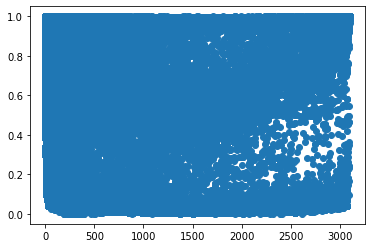

In [36]:
plt.scatter(x,y)
plt.show()

In [37]:
x.index(1550)

48011